## **Inicialização:**

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [181]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.5.0-bin-hadoop3')

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = spark.sparkContext

In [182]:
import pandas as pd
import geopandas as gpd
import json

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col, expr, when, count, udf, regexp_replace
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, FloatType

## **Importação e Tratamento Inicial do Dataset:**

In [ ]:
# Download dos Datasets do http do Google Drive para arquivo local

#SE:https://drive.google.com/file/d/1xNUnM98eKwX42kN8I2VKzc9A8RdSKzNp/view?usp=sharing
#NE:https://drive.google.com/file/d/1NTQk8mb9k7MJIu5ETSdemPrOC6BbKizy/view?usp=sharing
#S: https://drive.google.com/file/d/1iN4gZ22bpBRKGr8Uwyci6cJDV-HRh6mP/view?usp=sharing
#CO:https://drive.google.com/file/d/1C-7MTXC6Vp_TF6k-SdKiHOqjXnCawd0N/view?usp=sharing
#N: https://drive.google.com/file/d/1HbbJzr3cLMk1m537l-PWz6oS7uP4IE3Z/view?usp=sharing

!pip install gdown # Biblioteca para Download do arquivo csv no Drive
!gdown --id 1xNUnM98eKwX42kN8I2VKzc9A8RdSKzNp -O Pedidos_SE.csv
!gdown --id 1NTQk8mb9k7MJIu5ETSdemPrOC6BbKizy -O Pedidos_NE.csv
!gdown --id 1iN4gZ22bpBRKGr8Uwyci6cJDV-HRh6mP -O Pedidos_S.csv
!gdown --id 1C-7MTXC6Vp_TF6k-SdKiHOqjXnCawd0N -O Pedidos_CO.csv
!gdown --id 1HbbJzr3cLMk1m537l-PWz6oS7uP4IE3Z -O Pedidos_N.csv

In [5]:
# Carregando os DataFrames
pedidos_SE = spark.read.csv("/content/Pedidos_SE.csv", sep=";", inferSchema=True, header=True)
pedidos_NE = spark.read.csv("/content/Pedidos_NE.csv", sep=";", inferSchema=True, header=True)
pedidos_S = spark.read.csv("/content/Pedidos_S.csv", sep=";", inferSchema=True, header=True)
pedidos_CO = spark.read.csv("/content/Pedidos_CO.csv", sep=";", inferSchema=True, header=True)
pedidos_N = spark.read.csv("/content/Pedidos_N.csv", sep=";", inferSchema=True, header=True)

In [ ]:
# Unindo todos os DataFrames
pedidos_Brasil = pedidos_SE.union(pedidos_NE).union(pedidos_S).union(pedidos_N).union(pedidos_CO)
pedidos_Brasil.show(1)

In [7]:
# Contar o número de linhas do Dataframe
num_rows = pedidos_Brasil.count()
print(f"O DataFrame possui {num_rows} linhas.")

O DataFrame possui 10946092 linhas.


In [8]:
# Filtrando pedidos apenas com tipo de geração fotovoltaica
ufv_pedidos = pedidos_Brasil.filter(pedidos_Brasil.SigTipoGeracao == 'UFV')

In [9]:
# Contar o número de valores NULL nas colunas de interesse
null_count_1 = ufv_pedidos.select(count(when(col("DscStatusConexao").isNull(), 1))).collect()[0][0]
null_count_2 = ufv_pedidos.select(count(when(col("DscModalidade").isNull(), 1))).collect()[0][0]
null_count_3 = ufv_pedidos.select(count(when(col("DscSubgrupoTarifario").isNull(), 1))).collect()[0][0]
null_count_4 = ufv_pedidos.select(count(when(col("MdaPotencia").isNull(), 1))).collect()[0][0]

In [10]:
# Exibir o número de valores NULL
print(f"A coluna 'DscStatusConexao' possui {null_count_1} valores NULL.")
print(f"A coluna 'DscModalidade' possui {null_count_2} valores NULL.")
print(f"A coluna 'DscSubgrupoTarifario' possui {null_count_3} valores NULL.")
print(f"A coluna 'MdaPotencia' possui {null_count_4} valores NULL.")

A coluna 'DscStatusConexao' possui 0 valores NULL.
A coluna 'DscModalidade' possui 156623 valores NULL.
A coluna 'DscSubgrupoTarifario' possui 29789 valores NULL.
A coluna 'MdaPotencia' possui 13305 valores NULL.


In [ ]:
# Identificando as distribuidoras existentes
distribuidoras_Br = ufv_pedidos.select("SigAgenteDistribuicao").distinct().collect()
nomes_distribuidoras = [row.SigAgenteDistribuicao for row in distribuidoras_Br]
nomes_distribuidoras.sort()

for nome in nomes_distribuidoras:
    print(nome)

In [12]:
# Construir uma expressão condicional para agrupar as distribuidoras
expr_agrupar_distribuidoras = col("SigAgenteDistribuicao")
distribuidoras_agrupadas = {
    "CPFL": ["CPFL Santa Cruz", "CPFL Paulista", "CPFL Piratininga","RGE"],
    "Energisa": ["Energisa Sul-Sudeste", "Energisa MG","Energisa Borborema", "Energisa PB","Energisa SE","Energisa MS", "Energisa MT","Energisa TO","Energisa AC","Energisa RO"],
    "Equatorial": ["Equatorial PI", "Equatorial MA","Equatorial AL","CEA Equatorial", "Equatorial PA","CEEE Equatorial"],
    "EDP": ["EDP ES", "EDP SP"],
    "ENEL": ["Enel RJ", "Enel SP","Enel CE","Enel GO"],
    "Neoenergia": ["Neoenergia Coelba", "Neoenergia Elektro", "Neoenergia Cosern","Neoenergia Bras�lia","Neoenergia Pernambuco"],
    "Joao Cesa": ["Jo�o Cesa"],
    "Cooperalianca": ["Cooperalian�a"],
}

# Construir a expressão de agrupamento
for nome_agrupado, nomes_originais in distribuidoras_agrupadas.items():
    condicao = expr("SigAgenteDistribuicao IN ({})".format(','.join([f"'{nome}'" for nome in nomes_originais])))
    expr_agrupar_distribuidoras = when(condicao, nome_agrupado).otherwise(expr_agrupar_distribuidoras)

# Aplicar a expressão de agrupamento ao DataFrame
ufv_pedidos = ufv_pedidos.withColumn("Distribuidora", expr_agrupar_distribuidoras)

In [ ]:
# Obtendo as distribuidoras após filtro
valores_distintos = ufv_pedidos.select("Distribuidora").distinct().collect()

# Mostrando os valores distintos
valores_distintos

In [14]:
# Obtendo percentual de pedidos de cada distribuidora

total_por_distribuidora = ufv_pedidos.groupBy("Distribuidora").agg(count("*").alias("Total_Por_Distribuidora"))
total_geral = total_por_distribuidora.agg({"Total_Por_Distribuidora": "sum"}).collect()[0][0]
proporcao_por_distribuidora = total_por_distribuidora.withColumn("Percentual", (col("Total_Por_Distribuidora") / total_geral)*100)

In [15]:
# Filtrando apenas as distribuidoras que possuem uma proporção de pedidos maior que 1%
distribuidoras_filtradas = proporcao_por_distribuidora.filter(col("Percentual") >= 1.0)
distribuidoras_filtradas.show()

+-------------+-----------------------+------------------+
|Distribuidora|Total_Por_Distribuidora|        Percentual|
+-------------+-----------------------+------------------+
|   Neoenergia|                1834505| 16.80227363588945|
|      Cemig-D|                1581161|14.481890092638938|
|         CPFL|                1911045|  17.5033052624541|
|         ENEL|                1167598|10.694057030489015|
|     Energisa|                1239916| 11.35641926160872|
|        Light|                 220817|2.0224679995182355|
|          EDP|                 291473| 2.669607934278514|
|   Equatorial|                1114708|10.209636299772994|
|    Copel-Dis|                 849710| 7.782513501544898|
|   Celesc-Dis|                 507488| 4.648094304965244|
+-------------+-----------------------+------------------+



In [16]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
pd_df = distribuidoras_filtradas.toPandas()

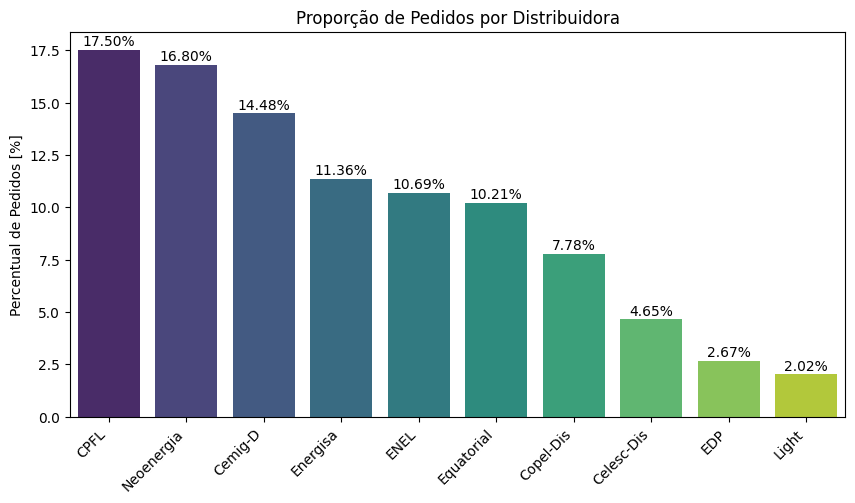

In [247]:
# Plot da Proporção de Pedidos de Cada Distribuidora

pd_df = pd_df.sort_values(by='Percentual', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Distribuidora', y='Percentual', data=pd_df, orient='v', palette="viridis")
plt.xticks(rotation=45, ha='right')

plt.title('Proporção de Pedidos por Distribuidora')
plt.xlabel('')
plt.ylabel('Percentual de Pedidos [%]')

# Adicionando os rótulos de valores
for i, value in enumerate(pd_df['Percentual']):
    ax.text(i, value + 0.4, f"{value:.2f}%", ha='center', va='center', fontsize=10)


plt.show()

In [18]:
# Filtrando o DataFrame original com as distribuidoras selecionadas
df_filtrado = ufv_pedidos.join(distribuidoras_filtradas, "Distribuidora")

## **Análise Hipótese 1:**

*   Avaliação da existência de discrepâncias significativas entre diferentes distribuidoras no que tange à eficiência do atendimento às solicitações.

In [19]:
# Realizando agrupamento por Distribuidora e Status do Pedido, calculando a contagem
df_grouped = df_filtrado.groupBy("Distribuidora", "DscStatusConexao").count()

In [20]:
# Calculando a proporção por categoria de Status do Pedido para cada Distribuidora

windowSpec = Window.partitionBy("Distribuidora")
df_with_proportion = df_grouped.withColumn("Total", F.sum("count").over(windowSpec))
df_with_proportion = df_with_proportion.withColumn("Percentual", (F.col("count") / F.col("Total"))*100)
df_with_proportion.show(1)

+-------------+----------------+------+-------+------------------+
|Distribuidora|DscStatusConexao| count|  Total|        Percentual|
+-------------+----------------+------+-------+------------------+
|      Cemig-D| Pedidos Negados|481960|1581161|30.481399427382787|
+-------------+----------------+------+-------+------------------+
only showing top 1 row



In [21]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
df_pandas = df_with_proportion.toPandas()

#### Visualização

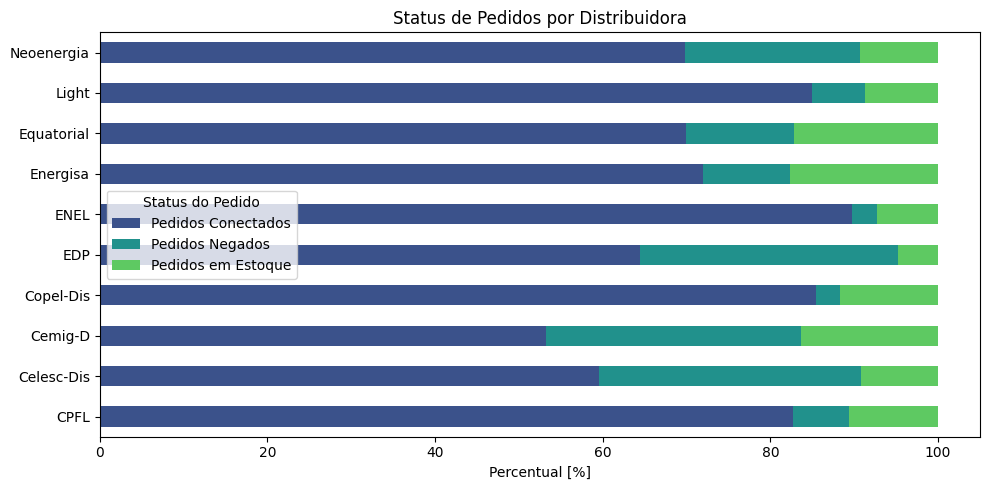

In [241]:
# Plot Barras Empilhadas Normalizadas

# Remodelagem do DataFrame para ter status de pedido em cada coluna e cada distribuidora como uma linha
df_pivot = df_pandas.pivot(index='Distribuidora', columns='DscStatusConexao', values='Percentual')
df_pivot = df_pivot.fillna(0)  # Substitui os valores NaN por 0, se houver

colors = sns.color_palette("viridis", n_colors=df_pivot.shape[1])
ax = df_pivot.plot(kind='barh', stacked=True, figsize=(10,5), color=colors)
plt.legend(title='Status do Pedido')
plt.title('Status de Pedidos por Distribuidora')
plt.xlabel('Percentual [%]')
plt.ylabel('')
plt.tight_layout()
plt.show()

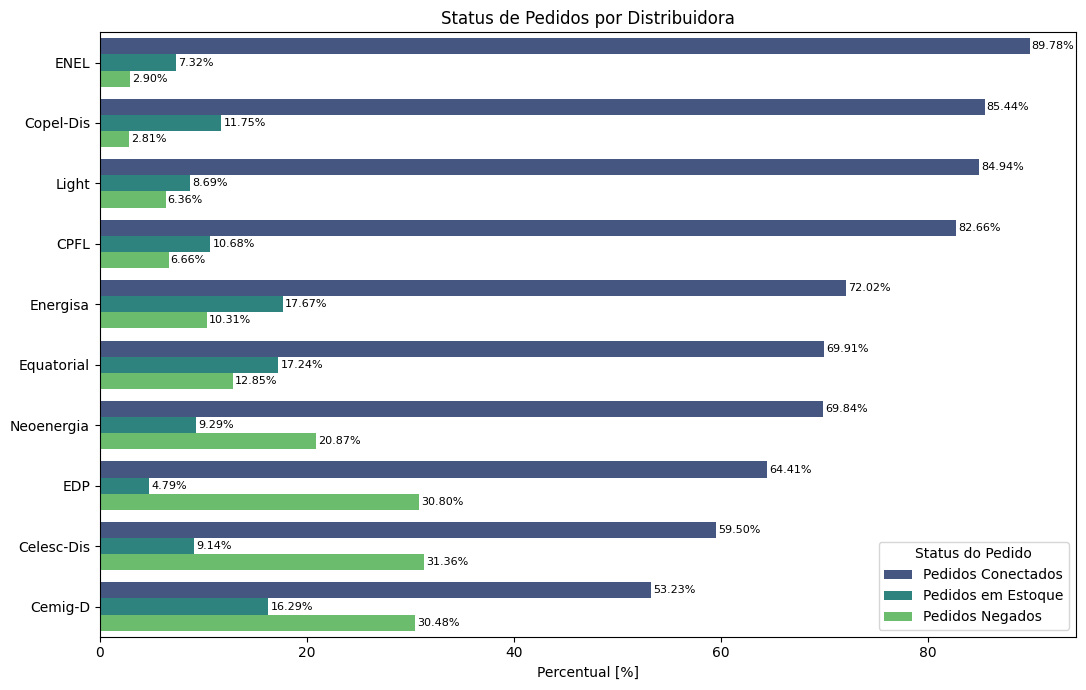

In [185]:
# Filtrar os 'Pedidos_Conectado' do DataFrame
df_connected = df_pandas[df_pandas['DscStatusConexao'] == 'Pedidos Conectados']

# Ordenar o DataFrame df_connected pela proporção de 'Pedidos_Conectado'
df_connected = df_connected.sort_values(by='Percentual', ascending=False)

# Ordenar o DataFrame com base no DataFrame df_connected
df_sorted = df_pandas.set_index('Distribuidora').loc[df_connected['Distribuidora']].reset_index()

plt.figure(figsize=(11,7))
ax = sns.barplot(data=df_sorted, y='Distribuidora', x='Percentual', hue='DscStatusConexao', orient='h', errorbar=None, palette="viridis")

# Adicionando rótulos
num_categories = len(df_sorted['DscStatusConexao'].unique())
bar_width = 0.8  # Esta é uma estimativa, a largura padrão das barras no Seaborn/Matplotlib é geralmente 0.8
hue_categories = df_sorted['DscStatusConexao'].unique()

for i, distribuidora in enumerate(df_sorted['Distribuidora'].unique()):
    for j, status in enumerate(hue_categories):
        value = df_sorted[(df_sorted['Distribuidora'] == distribuidora) & (df_sorted['DscStatusConexao'] == status)]['Percentual'].values[0]
        position = i - bar_width/2 + (bar_width/num_categories)*(j + 0.5)  # Ajusta a posição de cada rótulo
        ax.text(value+0.2, position, f"{value:.2f}%", color='black', va='center', ha='left', fontsize=8)

plt.legend(title='Status do Pedido')
plt.title('Status de Pedidos por Distribuidora')
plt.xlabel('Percentual [%]')
plt.ylabel('')
plt.tight_layout()
plt.show()


## **Análise Hipótese 2:**

*   Avaliação se alguns estados têm uma proporção maior de solicitações negadas.

In [186]:
# Agrupar pelo Nome do Estado (União Federativa) e Status de Conexão
grouped_df = (
    ufv_pedidos.groupBy("NomUF", "DscStatusConexao")
    .agg(F.count("*").alias("Quantidade"))
    .sort("NomUF", "DscStatusConexao")
)

In [187]:
# Definir a janela de partição pelo Estado
window_spec = Window.partitionBy("NomUF")

# Calcular a soma total de pedidos para cada Estado
total_df = grouped_df.withColumn("Total_Pedidos", F.sum("Quantidade").over(window_spec))

# Calcular a proporção de cada Status de Conexão para cada Estado
proportion_df = total_df.withColumn("Percentual", (F.col("Quantidade") / F.col("Total_Pedidos"))*100)

# Agrupar pelo Estado e pelo Status da Conexão para obter as proporções
grouped_proportion_df = (
    proportion_df.groupBy("NomUF", "DscStatusConexao")
    .agg(F.sum("Percentual").alias("Percentual"))
    .sort("NomUF", "DscStatusConexao")
)

In [ ]:
# Pivotar o DataFrame para ter uma coluna para cada Estado
pivoted_proportion_df = (
    grouped_proportion_df.groupBy("DscStatusConexao")
    .pivot("NomUF")
    .agg(F.first("Percentual"))
)

# Visualização de proporção de pedidos por Estado em forma de Tabela
pivoted_proportion_df.show()

In [189]:
# Filtrando apenas os pedidos negados (Pedidos Negados + Pedidos Em Estoque)

# Criar condição de filtro
condicao = (grouped_proportion_df.DscStatusConexao == 'Pedidos Negados') | (grouped_proportion_df.DscStatusConexao == 'Pedidos em Estoque')

# Filtrar o DataFrame com base na condição
negados_UFs__df = grouped_proportion_df.filter(condicao)

# Agrupar por 'NomUF' e somar os valores de 'Percentual' para as categorias desejadas
negados_UFs__df = negados_UFs__df.groupBy('NomUF').agg(F.sum('Percentual').alias('Soma_Proportion'))


In [190]:
# Criando Dicionário para relacionar Nome do Estado com Sigla do Estado

uf_codigos = {
    'ACRE': 'AC',
    'ALAGOAS': 'AL',
    'AMAPA': 'AP',
    'AMAZONAS': 'AM',
    'BAHIA': 'BA',
    'CEARA': 'CE',
    'DISTRITO FEDERAL': 'DF',
    'ESPIRITO SANTO': 'ES',
    'GOIAS': 'GO',
    'MARANHAO': 'MA',
    'MATO GROSSO': 'MT',
    'MATO GROSSO DO SUL': 'MS',
    'MINAS GERAIS': 'MG',
    'PARA': 'PA',
    'PARAIBA': 'PB',
    'PARANA': 'PR',
    'PERNAMBUCO': 'PE',
    'PIAUI': 'PI',
    'RIO DE JANEIRO': 'RJ',
    'RIO GRANDE DO NORTE': 'RN',
    'RIO GRANDE DO SUL': 'RS',
    'RONDONIA': 'RO',
    'RORAIMA': 'RR',
    'SANTA CATARINA': 'SC',
    'SAO PAULO': 'SP',
    'SERGIPE': 'SE',
    'TOCANTINS': 'TO'
}

In [191]:
# Define uma UDF (User-Defined Function) para fazer o mapeamento usando o dicionário uf_codigos
def map_uf_to_cod(uf):
    return uf_codigos.get(uf)

# Registra a UDF
map_udf = udf(map_uf_to_cod, StringType())

# Adiciona a nova coluna ao DataFrame
negados_UFs__df = negados_UFs__df.withColumn('SIGLA_UF', map_udf('NomUF'))

In [192]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
negados_UFs__df = negados_UFs__df.toPandas()

#### Visualização

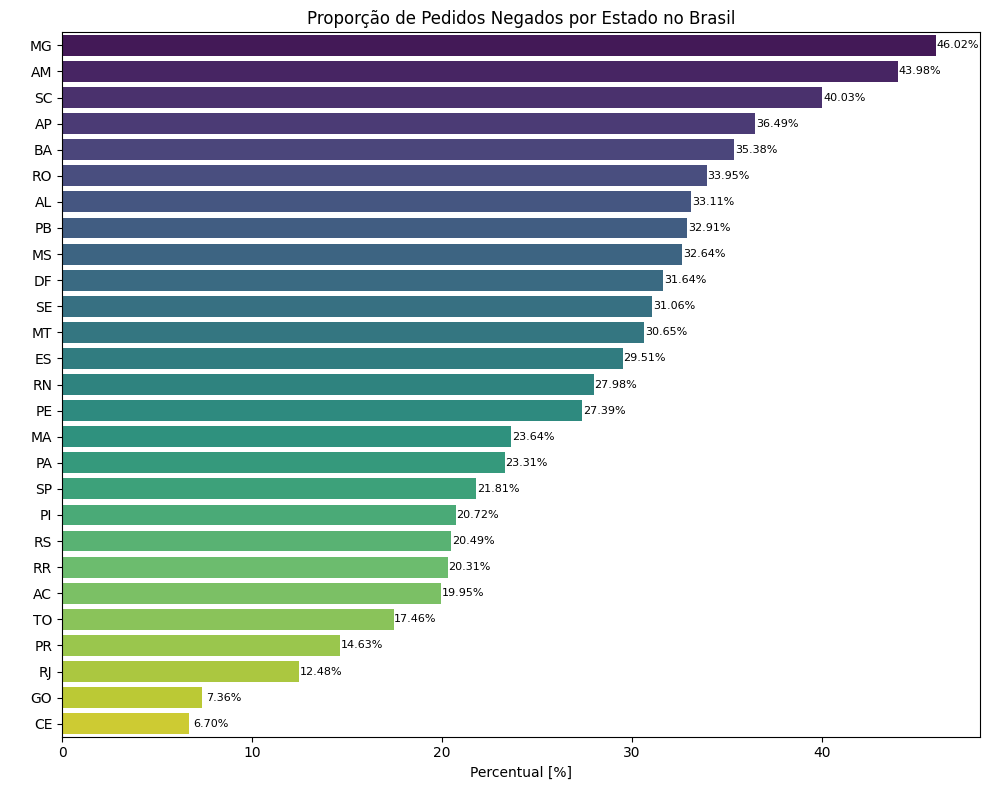

In [245]:
# Plot da proporção de pedidos negados por Estado no Brasil com Gráfico de Barras

# Ordenando os resultado
negados_UFs__df = negados_UFs__df.sort_values(by='Soma_Proportion', ascending=False)

plt.figure(figsize=(10,8))
ax = sns.barplot(data=negados_UFs__df, x='Soma_Proportion', y='SIGLA_UF', palette='viridis', orient='h')

plt.title('Proporção de Pedidos Negados por Estado no Brasil')
plt.xlabel('Percentual [%]')
plt.ylabel(' ')
plt.tight_layout()

# Adicionando os rótulos de valores
for i, value in enumerate(negados_UFs__df['Soma_Proportion']):
    ax.text(value + 1.15,i, f"{value:.2f}%", ha='center', va='center', fontsize=8)

plt.show()

In [ ]:
# Download do shapefile do Brasil

#dbf:https://drive.google.com/file/d/1ZEYHg-BlKbNBoHgtqYzg0crShGhhvGzP/view?usp=sharing
#shp:https://drive.google.com/file/d/1qGiByFAcyjqRrDbpX0DJO591-JOkubtK/view?usp=sharing
#shx:https://drive.google.com/file/d/114ba_uae34uJ-6x5Z6v7ew2hh9GDuevp/view?usp=sharing

!gdown --id 1ZEYHg-BlKbNBoHgtqYzg0crShGhhvGzP -O BR_UF_2022.dbf
!gdown --id 1qGiByFAcyjqRrDbpX0DJO591-JOkubtK -O BR_UF_2022.shp
!gdown --id 114ba_uae34uJ-6x5Z6v7ew2hh9GDuevp -O BR_UF_2022.shx

In [194]:
# Plot da proporção de pedidos negados por Estado no Brasil com Mapa Chropleth

# Carregar o shapefile dos estados do Brasil
brasil_gdf = gpd.read_file('/content/BR_UF_2022.shp')

In [195]:
# Supondo que a coluna com o nome do estado no GeoDataFrame é 'SIGLA_UF'
mapa_df = brasil_gdf.merge(negados_UFs__df, left_on='SIGLA_UF', right_on='SIGLA_UF')

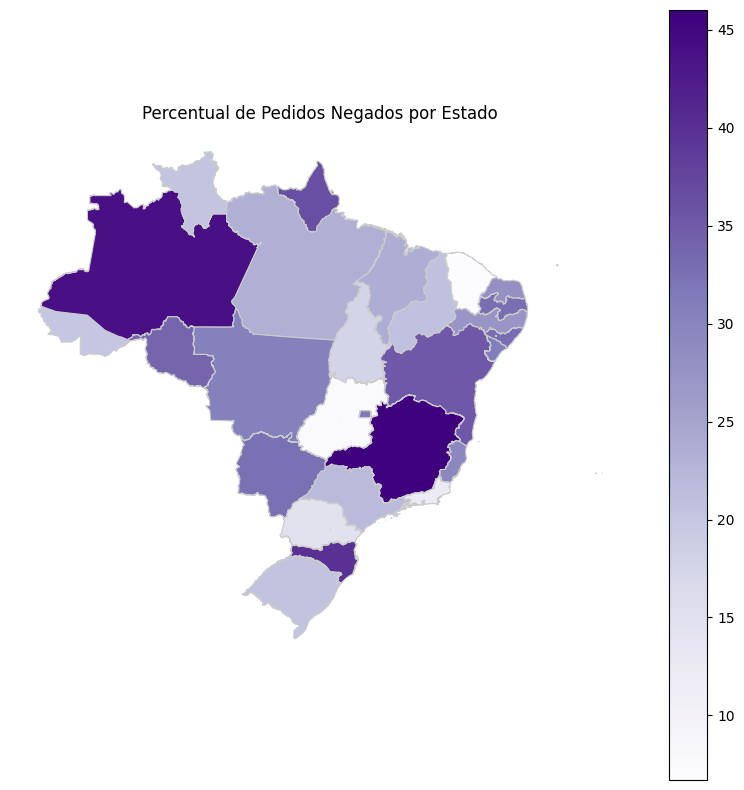

In [196]:
# Plotar o mapa choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mapa_df.plot(column='Soma_Proportion', cmap='Purples', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')
plt.title('Percentual de Pedidos Negados por Estado')
plt.show()


In [197]:
# Plot da proporção de pedidos negados por Estado no Brasil com Mapa Chropleth Utilizando Plotly

# Lendo o arquivo georeferenciado no formato JSON
brasil_gdf.to_file('brasil.geojson', driver='GeoJSON')

# Carregar o arquivo geojson
with open('brasil.geojson', 'r') as file:
    brasil_geojson = json.load(file)

In [233]:
# Criando o mapa

mapa_gd_negados = px.choropleth_mapbox(
    data_frame = negados_UFs__df,
    geojson = brasil_geojson,
    locations = 'SIGLA_UF',
    featureidkey = 'properties.SIGLA_UF',
    color='Soma_Proportion',
    color_continuous_scale = 'blues',
    range_color = (0,50),
    mapbox_style = 'open-street-map',
    zoom = 2.5,
    center = {'lat': -17.14, 'lon': -57.33},
    opacity = 1,
    labels = {
        'Soma_Proportion' : 'Percentual de Pedidos Negados',
        'SIGLA_UF' : 'Estado do Brasil'
    },
    width = 1200,
    height = 800
)

In [234]:
#Salvando mapa no diretório
mapa_gd_negados.write_html("meu_mapa_choropleth.html")

## **Análise Hipótese 3:**

*   Analisar se solicitações de conexão para certos tipos de modalidades são mais propensas a serem negadas.

In [200]:
# Exluindo valores nulos da coluna vinculada a Modalidade de Geração
df_modalidade = ufv_pedidos.na.drop(how = "any", subset = ["DscModalidade"])

In [201]:
# Agrupar pela Modalidade de Geração e Status de Conexão
grouped_df = (
    df_modalidade.groupBy("DscModalidade", "DscStatusConexao")
    .agg(F.count("*").alias("Quantidade"))
    .sort("DscModalidade", "DscStatusConexao")
)

In [202]:
# Definir a janela de partição pela Modalidade de Geração
window_spec = Window.partitionBy("DscModalidade")

# Calcular a soma total de pedidos para cada Modalidade
total_df = grouped_df.withColumn("Total_Pedidos", F.sum("Quantidade").over(window_spec))

# Calcular a proporção de cada Status de Conexão para cada Modalidade
proportion_df = total_df.withColumn("Percentual", (F.col("Quantidade") / F.col("Total_Pedidos"))*100)

# Agrupar pela Modalidade e pelo Status da Conexão para obter as proporções
grouped_proportion_df = (
    proportion_df.groupBy("DscModalidade", "DscStatusConexao")
    .agg(F.sum("Percentual").alias("Percentual"))
    .sort("DscModalidade", "DscStatusConexao")
)

In [203]:
# Pivotar o DataFrame para ter uma coluna para cada Modalidade
pivoted_proportion_df = (
    grouped_proportion_df.groupBy("DscStatusConexao")
    .pivot("DscModalidade")
    .agg(F.first("Percentual"))
)

# Visualização de proporção de pedidos por Modalidade em forma de Tabela
pivoted_proportion_df.show()

+------------------+------------------+------------------+---------------------+------------------+
|  DscStatusConexao|AUTOCONSUMO REMOTO|             EMUCs|GERACAO COMPARTILHADA|     GERACAO LOCAL|
+------------------+------------------+------------------+---------------------+------------------+
|Pedidos em Estoque|13.334345364125586|2.0082336102462706|    16.60822743915572| 10.86111285467501|
|   Pedidos Negados|15.073602038557047|  9.03778902480412|   28.610524804364996|13.995789065762077|
|Pedidos Conectados| 71.59205259731736| 88.95397736494961|    54.78124775647929|  75.1430980795629|
+------------------+------------------+------------------+---------------------+------------------+



In [204]:
# Filtrando apenas os pedidos negados (Pedidos Negados + Pedidos Em Estoque)

# Criar condição de filtro
condicao = (grouped_proportion_df.DscStatusConexao == 'Pedidos Negados') | (grouped_proportion_df.DscStatusConexao == 'Pedidos em Estoque')

# Filtrar o DataFrame com base na condição
negados_modalidade_df = grouped_proportion_df.filter(condicao)

# Agrupar por 'DscModalidade' e somar os valores de 'Percentual' para as categorias desejadas
negados_modalidade_df = negados_modalidade_df.groupBy('DscModalidade').agg(F.sum('Percentual').alias('Soma_Proportion'))

In [205]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
negados_modalidade_pd = negados_modalidade_df.toPandas()

#### Visualização

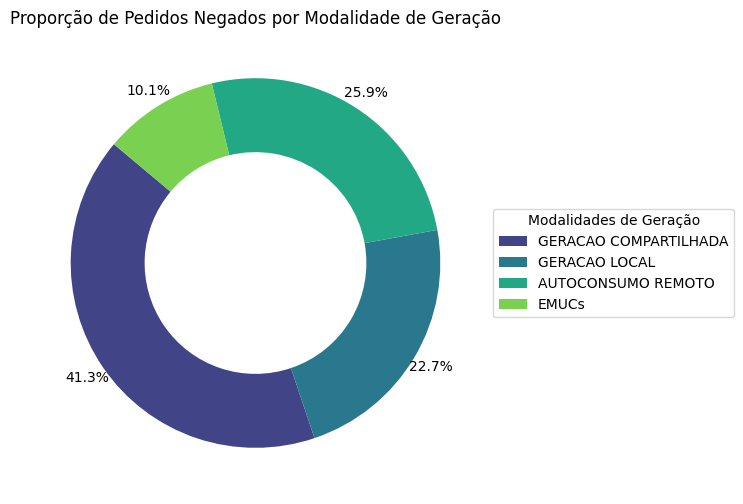

In [206]:
# Plot da proporção de pedidos negados por Modalidade de Geração

plt.figure(figsize=(6,6))

wedges, texts, autotexts = plt.pie(negados_modalidade_pd['Soma_Proportion'],
        autopct='%1.1f%%',  # Exibe a porcentagem no gráfico
        startangle=140,  # Define o ângulo inicial da primeira fatia
        colors=sns.color_palette("viridis", n_colors=len(negados_modalidade_pd['DscModalidade'])),
        pctdistance=1.1,
        wedgeprops=dict(width=0.4),
        textprops=dict(color="k"))  # A cor do texto é branca

# Melhorando a visualização das porcentagens aumentando a fonte e dando um negrito
plt.setp(autotexts, size=10)

# Adicionando a legenda
plt.legend(wedges, negados_modalidade_pd['DscModalidade'],
          title="Modalidades de Geração",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Adicionando o título ao gráfico
plt.title('Proporção de Pedidos Negados por Modalidade de Geração')

# Exibindo o gráfico
plt.show()


## **Análise Hipótese 4:**

*   Analisar se o subgrupo tarifário ao qual o consumidor pertence influencia o status da conexão.

In [207]:
# Exluindo valores nulos da coluna vinculada ao Subgrupo Tarifário
df_subgrupo = ufv_pedidos.na.drop(how = "any", subset = ["DscSubgrupoTarifario"])

In [208]:
# Agrupar pelo Subgrupo Tarifário e Status de Conexão
grouped_df = (
    df_subgrupo.groupBy("DscSubgrupoTarifario", "DscStatusConexao")
    .agg(F.count("*").alias("Quantidade"))
    .sort("DscSubgrupoTarifario", "DscStatusConexao")
)

In [209]:
# Definir a janela de partição pelo Subgrupo Tarifário
window_spec = Window.partitionBy("DscSubgrupoTarifario")

# Calcular a soma total de pedidos para cada Subgrupo
total_df = grouped_df.withColumn("Total_Pedidos", F.sum("Quantidade").over(window_spec))

# Calcular a proporção de cada Status de Conexão para cada Subgrupo
proportion_df = total_df.withColumn("Percentual", (F.col("Quantidade") / F.col("Total_Pedidos"))*100)

# Agrupar pelo Subgrupo Tarifário e pelo Status da Conexão para obter as proporções
grouped_proportion_df = (
    proportion_df.groupBy("DscSubgrupoTarifario", "DscStatusConexao")
    .agg(F.sum("Percentual").alias("Percentual"))
    .sort("DscSubgrupoTarifario", "DscStatusConexao")
)

In [ ]:
# Pivotar o DataFrame para ter uma coluna para cada Subgrupo
pivoted_proportion_df = (
    grouped_proportion_df.groupBy("DscStatusConexao")
    .pivot("DscSubgrupoTarifario")
    .agg(F.first("Percentual"))
)

# Visualização de proporção de pedidos por Subgrupo em forma de Tabela
pivoted_proportion_df.show()

In [211]:
# Filtrando apenas os pedidos negados (Pedidos Negados + Pedidos Em Estoque)

# Criar condição de filtro
condicao = (grouped_proportion_df.DscStatusConexao == 'Pedidos Negados') | (grouped_proportion_df.DscStatusConexao == 'Pedidos em Estoque')

# Filtrar o DataFrame com base na condição
negados_subgrupo_df = grouped_proportion_df.filter(condicao)

# Agrupar por 'DscSubgrupoTarifario' e somar os valores de 'Percentual' para as categorias desejadas
negados_subgrupo_df = negados_subgrupo_df.groupBy('DscSubgrupoTarifario').agg(F.sum('Percentual').alias('Soma_Proportion'))

In [212]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
negados_subgrupo_pd = negados_subgrupo_df.toPandas()

#### Visualização

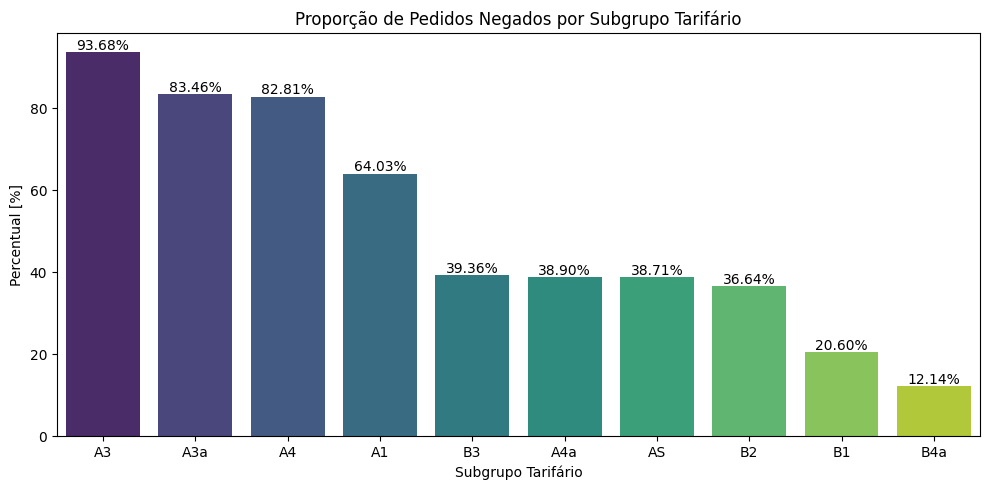

In [246]:
# Plot da proporção de pedidos negados por Modalidade de Geração

# Ordenando os resultado
negados_subgrupo_pd = negados_subgrupo_pd.sort_values(by='Soma_Proportion', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(data=negados_subgrupo_pd, x='DscSubgrupoTarifario', y='Soma_Proportion', palette='viridis', orient='v')

plt.title('Proporção de Pedidos Negados por Subgrupo Tarifário')
plt.xlabel('Subgrupo Tarifário')
plt.ylabel('Percentual [%]')
plt.tight_layout()

# Adicionando os rótulos de valores
for i, value in enumerate(negados_subgrupo_pd['Soma_Proportion']):
    ax.text(i, value + 1.5, f"{value:.2f}%", ha='center', va='center', fontsize=10)

plt.show()

## **Análise Hipótese 5:**

*   Analisar se a potência da central de microgeração ou minigeração está correlacionada com o status da conexão.

In [162]:
# Exluindo valores nulos da coluna vinculada a Potência da Central de Geração
df_potencia = ufv_pedidos.na.drop(how = "any", subset = ["MdaPotencia"])

In [163]:
# Construir uma expressão condicional para agrupar Pedidos Em Estoque e Pedidos Negados
expr_agrupar_pedidos = col("DscStatusConexao")
pedidos_agrupados = {
    "Pedidos Negados": ["Pedidos Negados", "Pedidos em Estoque"],
}

# Construir a expressão de agrupamento
for nome_agrupado, nomes_originais in pedidos_agrupados.items():
    condicao = expr("DscStatusConexao IN ({})".format(','.join([f"'{nome}'" for nome in nomes_originais])))
    expr_agrupar_pedidos = when(condicao, nome_agrupado).otherwise(expr_agrupar_pedidos)

# Aplicar a expressão de agrupamento ao DataFrame
df_potencia = df_potencia.withColumn("Status_Pedido", expr_agrupar_pedidos)

In [164]:
# Analisando o tipo das variáveis
df_potencia.printSchema()

root
 |-- DatGeracaoConjuntoDados: date (nullable = true)
 |-- SigAgenteDistribuicao: string (nullable = true)
 |-- NumCPFCNPJ: long (nullable = true)
 |-- CodMunicipioIBGE: integer (nullable = true)
 |-- NomUF: string (nullable = true)
 |-- NomMunicipio: string (nullable = true)
 |-- DatSolicitacao: date (nullable = true)
 |-- DatPrzEnvio: date (nullable = true)
 |-- DatInj: date (nullable = true)
 |-- DatLim: date (nullable = true)
 |-- DatOrcamentoConexao: date (nullable = true)
 |-- DatVistoria: date (nullable = true)
 |-- SigTipoGeracao: string (nullable = true)
 |-- DscModalidade: string (nullable = true)
 |-- DscMotivoSituacao: string (nullable = true)
 |-- DscNecessidadeObras: string (nullable = true)
 |-- DscSituacaoConexao: string (nullable = true)
 |-- DscStatusConexao: string (nullable = true)
 |-- DscSubgrupoTarifario: string (nullable = true)
 |-- MdaPotencia: string (nullable = true)
 |-- Distribuidora: string (nullable = true)
 |-- Status_Pedido: string (nullable = true

In [165]:
# Convertendo os valores de potencia de string para float

# Substituir vírgula por ponto
df_full = df_potencia.withColumn("MdaPotencia", regexp_replace(col("MdaPotencia"), ",", "."))

# Convertendo a coluna para float
df_full = df_full.withColumn("Potencia", col("MdaPotencia").cast(FloatType()))

In [166]:
# Descrevendo a distribuição com Dataframe Completo
desc_stats = df_full.describe(["Potencia"])
desc_stats.show()

+-------+-----------------+
|summary|         Potencia|
+-------+-----------------+
|  count|         10904890|
|   mean|48.36260431890502|
| stddev|6784.392455756257|
|    min|              0.0|
|    max|        8605294.0|
+-------+-----------------+



In [167]:
# Elevado desvio padrão em relação ao valor médio
# Portanto, selecionaremos apenas valores de Potencia menor que 100
df_full_filtered = df_full.filter(df_full['Potencia'] < 100)

# Descrevendo a distribuição com Dataframe Completo, porém com valores de Potencia < 100
desc_stats = df_full_filtered.describe(["Potencia"])
desc_stats.show()

+-------+------------------+
|summary|          Potencia|
+-------+------------------+
|  count|          10548623|
|   mean|11.456340663980146|
| stddev|15.677345275295096|
|    min|               0.0|
|    max|             99.96|
+-------+------------------+



In [168]:
# Amostrando os dados para viabilizara as visualizações
sampled_data = df_full.sample(fraction=0.1)

In [169]:
# Descrevendo a distribuição com amostra de 10% do Dataframe
desc_stats = sampled_data.describe(["Potencia"])
desc_stats.show()

+-------+------------------+
|summary|          Potencia|
+-------+------------------+
|  count|           1091458|
|   mean|50.291623541175035|
| stddev| 8240.552524626077|
|    min|               0.0|
|    max|         8605294.0|
+-------+------------------+



In [171]:
# Descrevendo a distribuição com amostra de 10% do Dataframe, porém com valores de Potência < 100
df_filtered = sampled_data.filter(sampled_data['Potencia'] < 100)
desc_stats = df_filtered.describe(["Potencia"])
desc_stats.show()

+-------+------------------+
|summary|          Potencia|
+-------+------------------+
|  count|           1055965|
|   mean|11.451580309276768|
| stddev|15.681555718632385|
|    min|               0.0|
|    max|              99.9|
+-------+------------------+



In [172]:
# Convertendo o DataFrame Spark para um DataFrame Pandas para o Plot
df_pd = df_filtered.toPandas()

#### Visualização

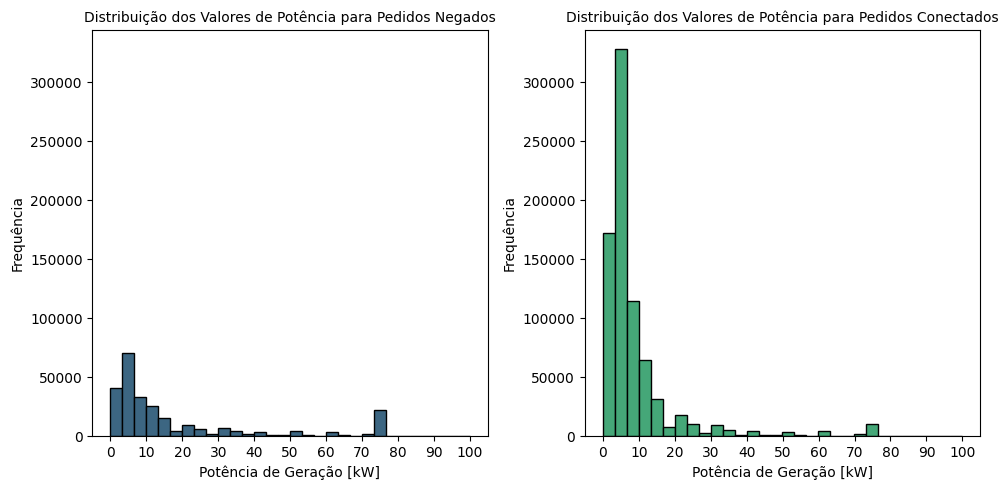

In [248]:
# Histogramas

fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Filtrando o DataFrame para incluir apenas os registros onde Status_Pedido é igual a 'Pedidos Negados'
pedidos_negados = df_pd[df_pd['Status_Pedido'] == 'Pedidos Negados']

# Filtrando o DataFrame para incluir apenas os registros onde Status_Pedido é igual a 'Pedidos Conectados'
pedidos_conectados = df_pd[df_pd['Status_Pedido'] == 'Pedidos Conectados']

# Plotando um histograma
axes[0].hist(pedidos_negados['Potencia'], bins=30, edgecolor='black', color='#3C6682')
axes[0].set_title('Distribuição dos Valores de Potência para Pedidos Negados', fontsize=10)
axes[0].set_xlabel('Potência de Geração [kW]', fontsize=10)
axes[0].set_ylabel('Frequência', fontsize=10)

# Plotando um histograma
axes[1].hist(pedidos_conectados['Potencia'], bins=30, edgecolor='black', color='#45A778')
axes[1].set_title('Distribuição dos Valores de Potência para Pedidos Conectados', fontsize=10)
axes[1].set_xlabel('Potência de Geração [kW]', fontsize=10)
axes[1].set_ylabel('Frequência', fontsize=10)

# Encontrar os limites globais para os eixos y
max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
min_ylim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])

# Aplicando os limites globais aos dois subplots
axes[0].set_ylim([min_ylim, max_ylim])
axes[1].set_ylim([min_ylim, max_ylim])

# Ajustando os ticks no eixo x para ambos os subplots
x_ticks = range(0, int(max(df_pd['Potencia'])) + 10, 10)
axes[0].set_xticks(x_ticks)
axes[1].set_xticks(x_ticks)

plt.tight_layout()
plt.show()

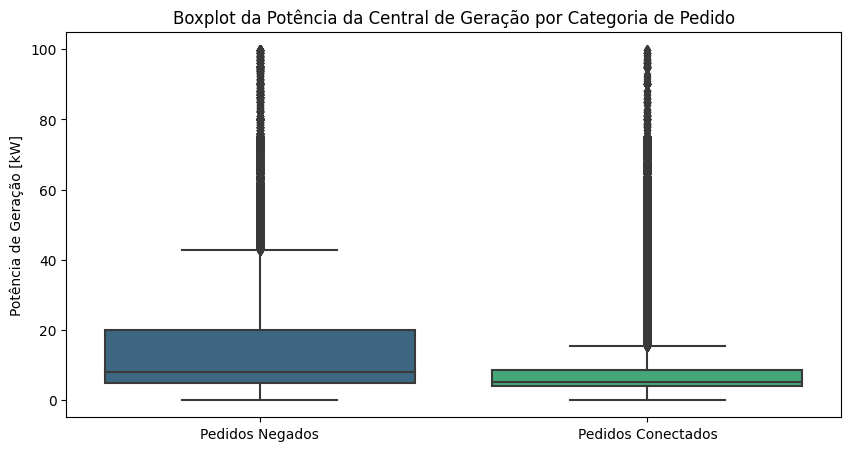

In [249]:
# Gráfico Boxplot

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_pd, x="Status_Pedido", y="Potencia", palette='viridis')
plt.title('Boxplot da Potência da Central de Geração por Categoria de Pedido')
plt.xlabel('')
plt.ylabel('Potência de Geração [kW]')
plt.show()

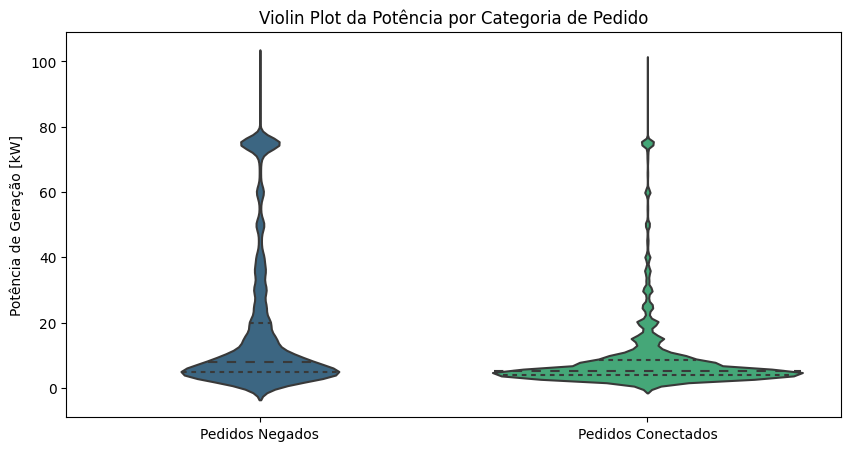

In [250]:
# Gráfico Violino

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_pd, x="Status_Pedido", y="Potencia", inner="quartile", palette='viridis')
plt.title('Violin Plot da Potência por Categoria de Pedido')
plt.xlabel('')
plt.ylabel('Potência de Geração [kW]')
plt.show()

## **Conclusões:**

*   **Hipótese 1:** Considerando a mesma ordem de quantidade de pedidos, identifica-se que há uma discrepância entre a proporção de pedidos aceitos em relação a cada distribuidora. Enquanto há distribuidoras com aproximadamente 80% dos pedidos aceitos, há empresas com aproximadamente 55%.

*   **Hipótese 2:** Verifica-se que há Estados no Brasil com uma proporção de pedidos negados maior comparado com outros. Inclusive, essa diferença é verificada entre Estados da mesma região. Os Estados com maior nível de indeferimento são Minas GErais, Amazonas e Santa Catarina, enquanto que em Goiás e Ceará possuem os menores percentuais.

*   **Hipótese 3:** Identifica-se que dependendo da modalidade de geração há uma tendência do pedido de conexão ser negado. Nota-se que para modalidade de geração do tipo compartilhada o atendimento é mais desafiador, enquanto que para os Empreendimentos de Múltiplas Unidades Consumidoras (EMUCs) há maior tendência de ter pedido aceito.

*   **Hipótese 4:** Consumidores de determinado subgrupo tarifário, especialmente aqueles do grupo A enfrentam maiores barreiras para ter um pedido deferido.

*   **Hipótese 5:** Dos resultados verifica-se que quando a potência da central geradora é entre 70 e 80 kW há uma tendência maior do pedido de conexão ser negado.

Oviamente, cada Estado e Distribuidora possuem realidades distintas, especialmente no que tange a qualidade da infraestrutura de rede elétrica. Não obstante, os resultados dessa análise propicia a identificação de empresas, modalidades de geração, e subgrupos tarifários em que os atendimentos de conexões de MMGD são mais viáveis de serem deferidos e/ou negados.

**Outras análises possíveis:**

*   Considerar o desempenho entre as distribuidoras de um mesmo grupo. No estudo apresentado as empresas foram agrupadas.
*   Verificar a relação da quantidade de pedidos por mês. Isso permite verificar se houve uma maior solicitação de pedidos em determinado mês, possibilitando analisar se há uma correlação com os pedidos negados por quantidade de pedidos no mês.
*   Realizar correlação entre as variáveis estudadas.
*   Realizar a correlação entre a proporção de atendimentos negados e o indice de reclamações através do Dataset "reclamacoes-n1e2-distribuidoras.csv" disponibilizado pela ANEEL.

